# New Section

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving NikeProductDescriptions.csv to NikeProductDescriptions.csv


Generating BERT embeddings: 100%|██████████| 155/155 [00:51<00:00,  3.00it/s]


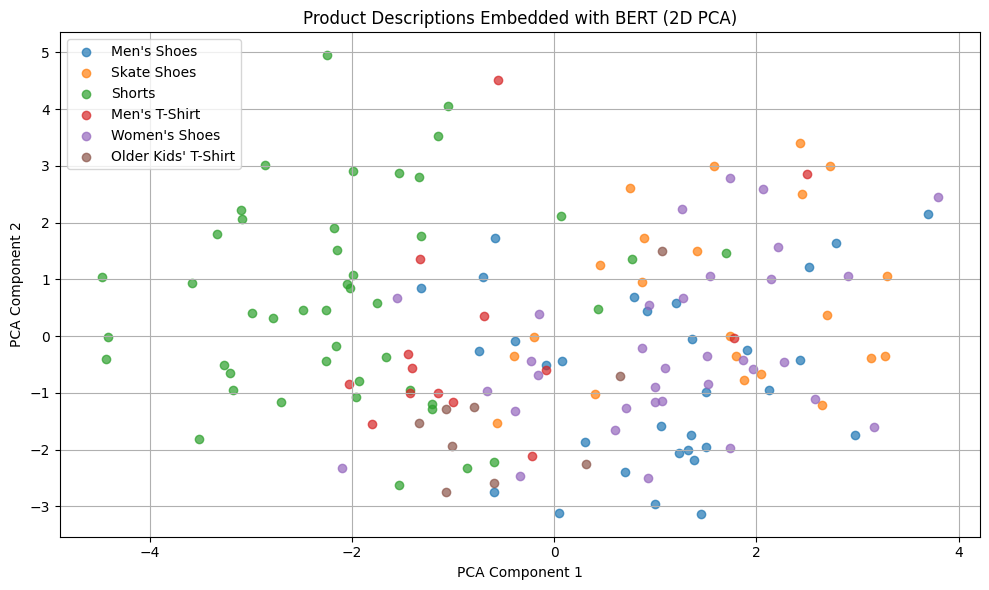

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

df = pd.read_csv("NikeProductDescriptions.csv")

target_subtitles = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]

filtered_df = df[
    df['Subtitle'].isin(target_subtitles) |
    df['Subtitle'].str.contains('Shorts', case=False)
].copy()

filtered_df.loc[filtered_df['Subtitle'].str.contains('Shorts', case=False), 'Subtitle'] = 'Shorts'


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()


def get_bert_cls_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token

embeddings = []
for desc in tqdm(filtered_df['Product Description'], desc="Generating BERT embeddings"):
    embeddings.append(get_bert_cls_embedding(desc))


pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
colors = {
    subtitle: color for subtitle, color in zip(
        filtered_df['Subtitle'].unique(),
        ['red', 'blue', 'green', 'purple', 'orange', 'brown']
    )
}
for subtitle in colors:
    idxs = filtered_df['Subtitle'] == subtitle
    plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=subtitle, alpha=0.7)

plt.title("Product Descriptions Embedded with BERT (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
